# Predict Maximum Expected Monthly Profit

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from pyspark.sql import SparkSession, functions, types, Row
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator
assert sys.version_info >= (3, 5)   # make sure we have Python 3.5+

In [2]:
spark = SparkSession.builder.appName('Make predictions').getOrCreate()
assert spark.version >= '3.0'   # make sure we have Spark 3.0+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

21/12/10 23:42:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
sns.set()

In [4]:
# Geocoder: Convert address to lat-lon pair
geocoder = Nominatim(user_agent = 'app_name')
geocode = RateLimiter(
    geocoder.geocode, 
    min_delay_seconds = 1, 
    return_value_on_exception = None
)

## Load externel models and datasets

In [5]:
# Locations of model and needed dataset
model_path = '../models/predict_price_GLM'
osm_feature_data_path = '../datasets/osm_features/'

In [6]:
# Load OSM data
osm_feature = spark.read.json(
    osm_feature_data_path, 
    schema = types.StructType([
        types.StructField('osm_id', types.LongType(), nullable = False), 
        types.StructField('lat', types.DoubleType(), nullable = False), 
        types.StructField('lon', types.DoubleType(), nullable = False), 
        types.StructField('category', types.StringType(), nullable = False), 
        types.StructField('name', types.StringType(), nullable = False)
    ])
)
# Modify column names and cache data
osm_feature = osm_feature.withColumn('lat_1', osm_feature['lat'])
osm_feature = osm_feature.withColumn('lon_1', osm_feature['lon'])
osm_feature = osm_feature[['osm_id', 'lat_1', 'lon_1', 'category', 'name']]
osm_feature.cache()

DataFrame[osm_id: bigint, lat_1: double, lon_1: double, category: string, name: string]

In [7]:
# Load price prediction model
model = PipelineModel.load(model_path)

## Utility functions

In [8]:
"""
Compute distance between any two lat-lon pairs
Reference: https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters
"""
def cal_pairwise_dist(lat_lon_paris):

    # An UDF that converts degrees to radians
    @functions.udf(returnType = types.DoubleType())
    def deg2Rad(deg):
        return deg * (np.pi / 180)

    # Radius of Earth in meters
    R = 6378137

    distances = lat_lon_paris.select(
        lat_lon_paris['lat_1'], 
        lat_lon_paris['lon_1'], 
        lat_lon_paris['category'], 
        lat_lon_paris['dummy_id'], 
        lat_lon_paris['lat_2'], 
        lat_lon_paris['lon_2'], 
        (deg2Rad(lat_lon_paris['lat_1']) - deg2Rad(lat_lon_paris['lat_2'])).alias('dlat'), 
        (deg2Rad(lat_lon_paris['lon_1']) - deg2Rad(lat_lon_paris['lon_2'])).alias('dlon')
    )

    distances = distances.withColumn(
        'a', 
        functions.sin(distances['dlat'] / 2) ** 2 \
        + functions.cos(deg2Rad(distances['lat_1'])) \
            * functions.cos(deg2Rad(distances['lat_2'])) \
            * functions.sin(distances['dlon'] / 2) ** 2
    )

    distances = distances.withColumn(
        'dist', 
        2 * R * functions.atan2(
            functions.sqrt(distances['a']), 
            functions.sqrt(1 - distances['a'])
        )
    )

    distances.cache()

    num_bus_2km = distances.select('dummy_id', 'dist') \
        .where((distances['category'] == 'bus') & (distances['dist'] <= 2000.0)) \
        .groupby('dummy_id').agg(functions.count('dist').alias('num_bus_2km'))

    num_subway_2km = distances.select('dummy_id', 'dist') \
        .where((distances['category'] == 'subway') & (distances['dist'] <= 2000.0)) \
        .groupby('dummy_id').agg(functions.count('dist').alias('num_subway_2km'))

    shops = distances.select('dummy_id', 'dist') \
        .where((distances['category'] == 'shopping') & (distances['dist'] <= 5000.0)) \
        .groupby('dummy_id').agg(
            functions.count('dist').alias('num_shop_2km'), 
            functions.min('dist').alias('nearest_shop(m)')

        )

    num_restaurant_2km = distances.select('dummy_id', 'dist') \
        .where((distances['category'] == 'restaurant') & (distances['dist'] <= 2000.0)) \
        .groupby('dummy_id').agg(functions.count('dist').alias('num_restaurant_2km'))

    # Result table
    res_table = num_bus_2km.join(num_subway_2km, on = ['dummy_id']) \
        .join(shops, on = ['dummy_id']) \
        .join(num_restaurant_2km, on = ['dummy_id'])

    return res_table

In [9]:
"""
get_prediction_api(dict):
    Input: param: dict
    param = {
        'address': str, 
        'postcode': str, 
        'house_start_date': str/int
        'neighbourhood_cleansed': str, 
        'room_type': str, 
        'accommodates': int, 
        'baths': int,  
        'beds': int, 
        'amenities': int
    }

    Return: Pandas Dataframe
    | 'price' | 'future_occupancy' | 'profit' |
"""
def get_prediction_api(param: dict):

    location = geocode(param['address'])
    if not location:
        return pd.DataFrame({'price': [], 'future_occupancy': [], 'profit': []})
    lat, lon = location.latitude, location.longitude

    lat_lon_paris = osm_feature.join(spark.createDataFrame([{
        'dummy_id': 'dummy_id', 
        'lat_2': lat, 
        'lon_2': lon
    }]))
    dist = cal_pairwise_dist(lat_lon_paris)
    dist.cache()

    param_df = spark.createDataFrame([{
        'latitude': lat, 
        'longitude': lon, 
        'num_bus_2km': dist.head(1)[0]['num_bus_2km'], 
        'num_subway_2km': dist.head(1)[0]['num_subway_2km'], 
        'num_shop_2km': dist.head(1)[0]['num_shop_2km'], 
        'nearest_shop(m)': dist.head(1)[0]['nearest_shop(m)'], 
        'num_restaurant_2km': dist.head(1)[0]['num_restaurant_2km'], 
        'neighbourhood_cleansed': param['neighbourhood_cleansed'], 
        'room_type': param['room_type'], 
        'accommodates': param['accommodates'], 
        'baths': param['baths'], 
        'beds': param['beds'], 
        'days': param['house_start_date'], 
        'amenities': param['amenities']
    }])

    occupancy = spark.createDataFrame(
        pd.DataFrame(
            np.arange(1, 1001) / 1000, 
            columns = ['future_occupancy']
        )
    )

    input_features = occupancy.join(param_df)
    # input_features.show()

    predictions = model.transform(input_features)

    # 1000 values, small enough to proceed with Pandas
    pd_pred = predictions[['future_occupancy', 'prediction']].toPandas()

    # Transform log_price to price and cast to int
    pd_pred['price'] = np.exp(pd_pred['prediction']).astype(int)

    # Infer data for missing price range
    missing = pd.DataFrame({
        'price': np.arange(0, pd_pred['price'].min() + 1), 
        'future_occupancy': 1.0
    })

    pd_pred = pd.concat([missing, pd_pred], axis = 0).reset_index(drop = True)

    # Merge data points with the same price
    pd_pred = pd_pred[['price', 'future_occupancy']].groupby('price').agg('mean').reset_index()

    # Compute profit
    pd_pred['profit'] = pd_pred['price'] * pd_pred['future_occupancy'] * 30

    return pd_pred

## Prediction

In [10]:
# Modify the input data here
input_data = {
    'address': 'Mainland St, Yaletown', 
    'postcode': 'V6B 5P2', 
    'house_start_date': 1500, 
    'neighbourhood_cleansed': 'Downtown', 
    'room_type': 'Entire home/apt', 
    'accommodates': 2, 
    'baths': 1, 
    'beds': 2, 
    'amenities': 15
}

In [11]:
# Get predictions
pd_pred = get_prediction_api(input_data)

21/12/10 23:43:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
21/12/10 23:43:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/10 23:43:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [12]:
# Optimal price
pd_pred[pd_pred['profit'] == pd_pred['profit'].max()]

,price,future_occupancy,profit
127,127,1.0,3810.0


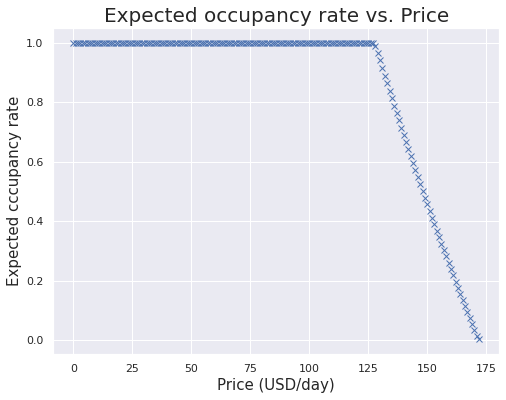

In [13]:
plt.figure(figsize = (8, 6))
plt.scatter(
    x = pd_pred['price'], 
    y = pd_pred['future_occupancy'], 
    marker = 'x', 
    linewidths = 1
)
plt.title("Expected occupancy rate vs. Price", fontsize = 20)
plt.xlabel("Price (USD/day)", fontsize = 15)
plt.ylabel("Expected cccupancy rate", fontsize = 15)
plt.show()

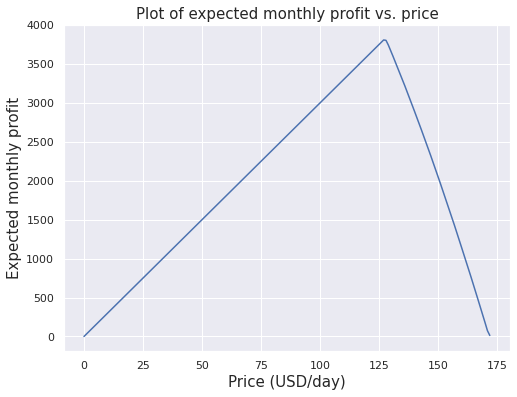

In [14]:
plt.figure(figsize = (8, 6))
plt.plot(
    pd_pred['price'], 
    pd_pred['profit']
)
plt.title("Plot of expected monthly profit vs. price", fontsize = 15)
plt.xlabel("Price (USD/day)", fontsize = 15)
plt.ylabel("Expected monthly profit", fontsize = 15)
plt.show()